**regression logistique **

In [2]:
pip install pandas numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [4]:
df = pd.read_csv(
    r"C:\Users\eyaou\OneDrive\Bureau\week1\social_media_viral_content_dataset (1).csv"
)

df.head()



,post_id,platform,content_type,topic,language,region,post_datetime,hashtags,views,likes,comments,shares,engagement_rate,sentiment_score,is_viral
0,SM_100000,Instagram,text,Sports,ur,UK,2024-12-10 00:00:00,#tech #funny #music,2319102,122058,15800,861,0.0598,0.464,1
1,SM_100001,Instagram,carousel,Sports,ur,Brazil,2024-10-13 00:00:00,#news #fyp #funny #ai #trending,2538464,110368,11289,54887,0.0695,-0.800,1
2,SM_100002,YouTube Shorts,video,Technology,ur,UK,2024-05-03 00:00:00,#ai #news,1051176,87598,47196,44132,0.1702,0.416,0
3,SM_100003,X,text,Politics,ur,US,2024-08-04 00:00:00,#ai #funny,5271440,329465,774,59736,0.0740,0.877,1
4,SM_100004,YouTube Shorts,text,Education,es,US,2024-03-28 00:00:00,#news #ai #viral #funny #fyp,3186256,199141,5316,83105,0.0903,0.223,1


In [5]:
print(df.dtypes)

post_id             object
platform            object
content_type        object
topic               object
language            object
region              object
post_datetime       object
hashtags            object
views                int64
likes                int64
comments             int64
shares               int64
engagement_rate    float64
sentiment_score    float64
is_viral             int64
dtype: object


In [6]:
print(df.isna().sum())

post_id            0
platform           0
content_type       0
topic              0
language           0
region             0
post_datetime      0
hashtags           0
views              0
likes              0
comments           0
shares             0
engagement_rate    0
sentiment_score    0
is_viral           0
dtype: int64


In [7]:
print(df.duplicated().sum())

0


In [8]:
#Quelle est la distribution (en %) des valeurs de la colonne is_viral ?
print(df["is_viral"].value_counts(normalize=True))

is_viral
1    0.699
0    0.301
Name: proportion, dtype: float64


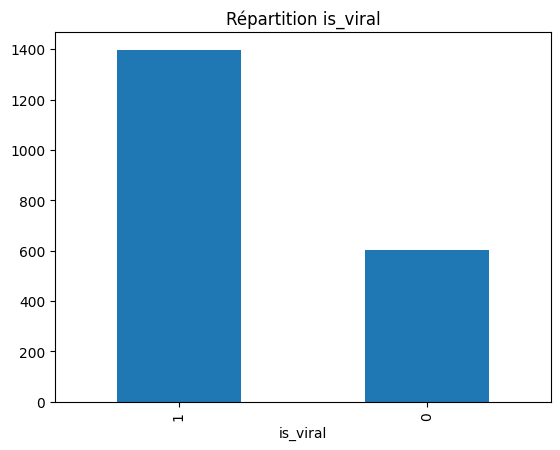

In [9]:
#Distribution de la cible (déséquilibre)
df["is_viral"].value_counts().plot(kind="bar")
plt.title("Répartition is_viral")
plt.show()

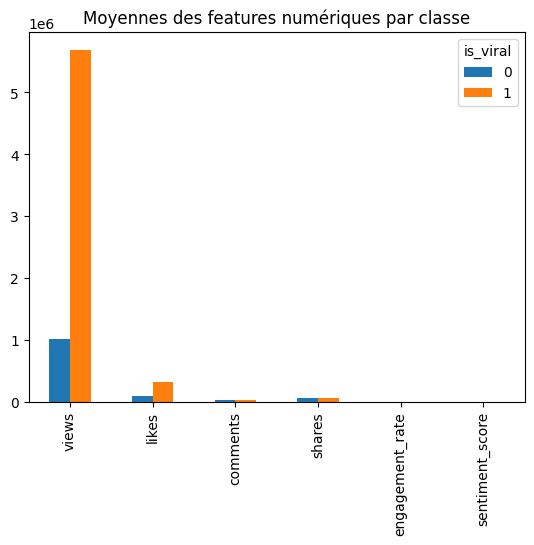

In [10]:
#Comparer viral vs non viral sur des variables numériques
num_cols = ["views","likes","comments","shares","engagement_rate","sentiment_score"]
df.groupby("is_viral")[num_cols].mean().T.plot(kind="bar")
plt.title("Moyennes des features numériques par classe")
plt.show()

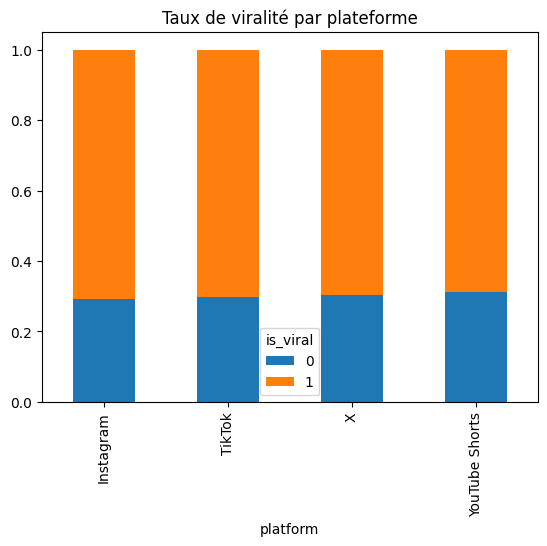

In [11]:
#Viralité par plateforme / type
pd.crosstab(df["platform"], df["is_viral"], normalize="index").plot(kind="bar", stacked=True)
plt.title("Taux de viralité par plateforme")
plt.show()


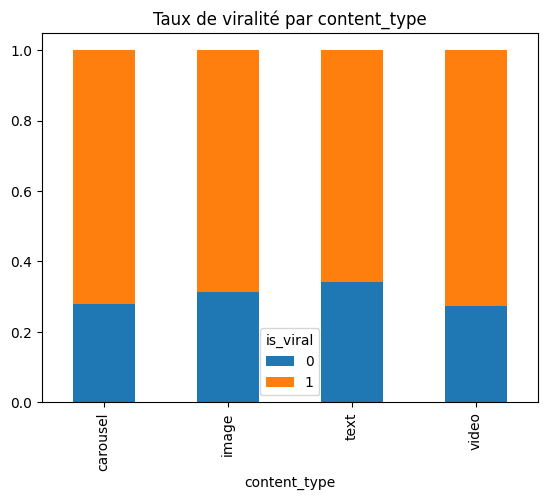

In [12]:
pd.crosstab(df["content_type"], df["is_viral"], normalize="index").plot(kind="bar", stacked=True)
plt.title("Taux de viralité par content_type")
plt.show()

In [13]:


def add_time_features(X):
    X = X.copy()
    dt = pd.to_datetime(X["post_datetime"], errors="coerce")
    X["hour"] = dt.dt.hour
    X["dayofweek"] = dt.dt.dayofweek
    X["month"] = dt.dt.month
    X["is_weekend"] = (X["dayofweek"] >= 5).astype(int)
    return X.drop(columns=["post_datetime"])

def add_hashtag_features(X):
    X = X.copy()
    h = X["hashtags"].fillna("").astype(str)

    X["num_hashtags"] = h.apply(lambda s: len([t for t in s.split() if t.startswith("#")]))
    X["has_trending"] = h.str.lower().str.contains(
        "trending|viral|fyp|explore|pourtoi"
    ).astype(int)
    X["hashtags_len"] = h.str.len()
    return X


In [14]:
target = "is_viral"
drop_cols = ["post_id"]

df_feat = add_time_features(df)
df_feat = add_hashtag_features(df_feat)

X = df_feat.drop(columns=[target] + drop_cols)
y = df_feat[target]


In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [16]:
#Étape 1 : définir cat_cols et num_cols
# Colonnes catégorielles
cat_cols = ["platform", "content_type", "topic", "language", "region"]

# Colonnes numériques
num_cols = [
    "views", "likes", "comments", "shares", "engagement_rate",
    "sentiment_score",
    "hour", "dayofweek", "month", "is_weekend",
    "num_hashtags", "has_trending", "hashtags_len"
]


In [17]:
# Étape 2 : définir le preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocess_logreg = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

# Appliquer le preprocessing
X_transformed = preprocess_logreg.fit_transform(X)

# Vérifier la forme (correct)
X_transformed.shape


# Récupérer les noms de colonnes après transformation
cat_feature_names = preprocess_logreg.named_transformers_['cat'].get_feature_names_out(cat_cols)
num_feature_names = num_cols
all_feature_names = list(cat_feature_names) + list(num_feature_names)

# Convertir en DataFrame
X_transformed_df = pd.DataFrame(
    X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed,
    columns=all_feature_names
)

# Visualiser les 5 premières lignes
X_transformed_df.head()


,platform_Instagram,platform_TikTok,platform_X,platform_YouTube Shorts,content_type_carousel,content_type_image,content_type_text,content_type_video,topic_Education,topic_Entertainment,...,shares,engagement_rate,sentiment_score,hour,dayofweek,month,is_weekend,num_hashtags,has_trending,hashtags_len
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.691951,-0.183164,0.808268,0.0,-1.008549,1.613283,-0.654654,-0.428810,-2.304159,-0.357103
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.170658,-0.165044,-1.390881,0.0,1.482925,1.032913,1.527525,1.382426,0.433998,1.231197
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.200133,0.023067,0.724756,0.0,0.486336,-0.418011,-0.654654,-1.334428,-2.304159,-1.680686
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.337832,-0.156638,1.526819,0.0,1.482925,0.452543,1.527525,-1.334428,-2.304159,-1.548327
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.143505,-0.126189,0.388968,0.0,-0.011959,-0.998381,-0.654654,1.382426,0.433998,0.834122


In [26]:
#Étape 3 : maintenant le pipeline Logistic Regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline(steps=[
    ("prep", preprocess_logreg),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

In [27]:
#Étape 4 : K-Folds (si pas encore fait)
from sklearn.model_selection import StratifiedKFold, cross_validate

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "roc_auc": "roc_auc"
}

scores = cross_validate(
    logreg_pipeline,
    X, y,
    cv=skf,
    scoring=scoring
)

for metric in scoring:
    print(metric, ":", scores["test_" + metric].mean())


f1 : 0.980680927266873
precision : 0.9977611109032948
recall : 0.9642242703533025
roc_auc : 0.9985026352760957


In [25]:
print(cat_cols)
print(num_cols[:5])
print(type(preprocess_logreg))
print(type(logreg_pipeline))


['platform', 'content_type', 'topic', 'language', 'region']
['views', 'likes', 'comments', 'shares', 'engagement_rate']
<class 'sklearn.compose._column_transformer.ColumnTransformer'>
<class 'sklearn.pipeline.Pipeline'>


In [18]:
# ===============================
# Étape 5 : Entraînement final du modèle (pour la loss)
# ===============================

final_logreg_pipeline = Pipeline(steps=[
    ("prep", preprocess_logreg),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

final_logreg_pipeline.fit(X, y)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

In [19]:
from sklearn.metrics import log_loss

# Probabilités prédites
y_proba = final_logreg_pipeline.predict_proba(X)

# Log loss finale
final_log_loss = log_loss(y, y_proba)

print(f"Log loss finale (régression logistique) : {final_log_loss:.4f}")


Log loss finale (régression logistique) : 0.0656
